In [7]:

import os
import time
from contextlib import nullcontext

import psutil
import hydra
from hydra.utils import to_absolute_path
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
import torch
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import nvtx
import wandb

from physicsnemo import Module
from physicsnemo.models.diffusion import UNet, EDMPrecondSuperResolution
from physicsnemo.distributed import DistributedManager
from physicsnemo.metrics.diffusion import RegressionLoss, ResidualLoss, RegressionLossCE
from physicsnemo.utils.patching import RandomPatching2D
from physicsnemo.launch.logging.wandb import initialize_wandb
from physicsnemo.launch.logging import PythonLogger, RankZeroLoggingWrapper
from physicsnemo.launch.utils import (
    load_checkpoint,
    save_checkpoint,
    get_checkpoint_dir,
)
from physicsnemo.experimental.metrics.diffusion import tEDMResidualLoss
from physicsnemo.experimental.models.diffusion.preconditioning import (
    tEDMPrecondSuperRes,
)

from datasets.dataset import init_train_valid_datasets_from_config, register_dataset
from helpers.train_helpers import (
    set_patch_shape,
    set_seed,
    configure_cuda_for_consistent_precision,
    compute_num_accumulation_rounds,
    handle_and_clip_gradients,
    is_time_for_periodic_task,
)


ImportError: TensorBoard logging requires TensorBoard version 1.15 or above

Valid tiles: [(2, 4), (3, 4), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 4), (6, 5)]
Number of valid tiles: 9


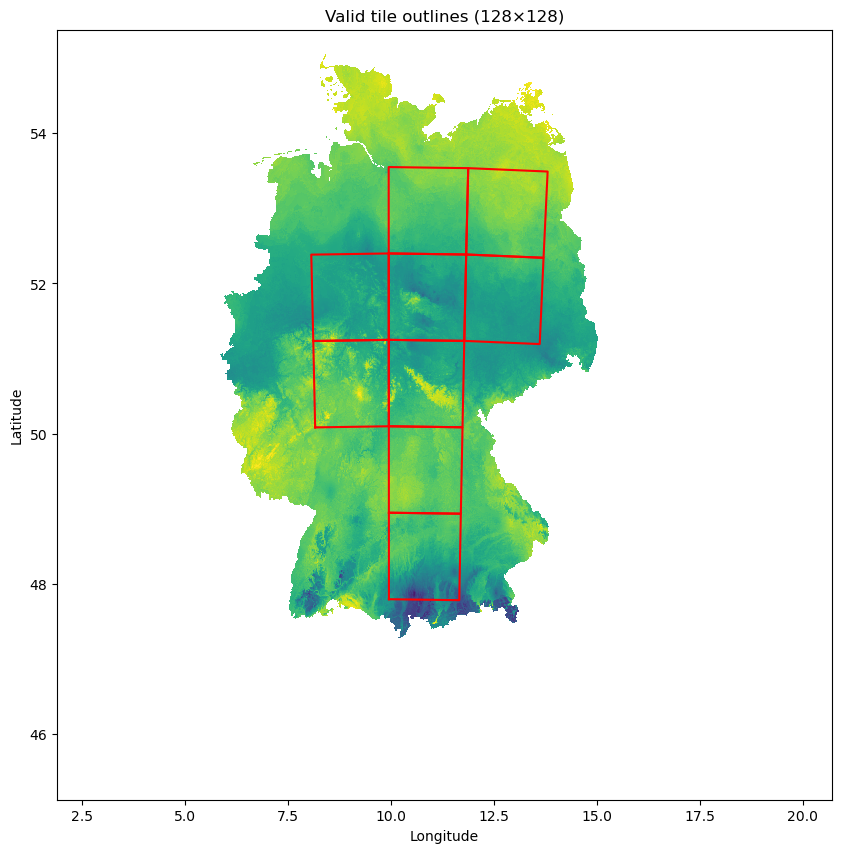

In [45]:
import numpy as np
import xarray as xr

fp = "/beegfs/muduchuru/data/hyras/HURS/hurs_hyras_1_2022_v6-0_de.nc"
ds = xr.open_dataset(fp)
lon = ds['lon']
lat = ds['lat']

data = ds['hurs'].isel(time=0)

H, W = data.shape
tile = 128

valid_tiles = []

for i in range(H // tile):
    for j in range(W // tile):
        block = data.values[i*tile:(i+1)*tile, j*tile:(j+1)*tile]

        # Mask valid values: finite AND not -999
        mask = np.isfinite(block) & (block != -999)

        if np.all(mask):
            valid_tiles.append((i, j))

print("Valid tiles:", valid_tiles)
print("Number of valid tiles:", len(valid_tiles))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Plot background data
plt.pcolormesh(lon, lat, data, cmap='viridis')

# Overlay tile boundaries
for (i, j) in valid_tiles:

    # tile corners (in data index space)
    i0, i1 = i*tile, (i+1)*tile
    j0, j1 = j*tile, (j+1)*tile

    # corresponding lon/lat corners
    xs = [
        lon[i0, j0], lon[i0, j1],
        lon[i1, j1], lon[i1, j0],
        lon[i0, j0]
    ]
    ys = [
        lat[i0, j0], lat[i0, j1],
        lat[i1, j1], lat[i1, j0],
        lat[i0, j0]
    ]

    plt.plot(xs, ys, color='red', linewidth=1.5)

plt.title("Valid tile outlines (128×128)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [42]:
data

<xarray.DataArray 'rsds' (y: 220, x: 240)> Size: 211kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2020-01-01T12:00:00
    lon      (y, x) float32 211kB ...
    lat      (y, x) float32 211kB ...
  * x        (x) float64 2kB 3.808e+06 3.812e+06 ... 4.998e+06 5.002e+06
  * y        (y) float64 2kB 2.488e+06 2.492e+06 ... 3.578e+06 3.582e+06
Attributes:
    standard_name:      surface_downwelling_shortwave_flux_in_air
    long_name:          Daily Mean Global Shortwave Radiation
    units:              W m-2
    cell_methods:       time: mean
    CoordinateSystems:  LatLonCoordinateSystem ProjectionCoordinateSystem
    esri_pe_string:     PROJCS["ETRS_1989_LAEA",GEOGCS["GCS_ETRS_1989",DATUM[...
    grid_mapping:       crs

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
import os

# -----------------------------
# Load datasets
# -----------------------------
ds_inv = xr.open_dataset("corrdiff_output_2024.nc")
lat = ds_inv["lat"]
lon = ds_inv["lon"]
ds_truth = xr.open_dataset("corrdiff_output_2024.nc", group="truth", decode_times=True)
ds_pred = xr.open_dataset("corrdiff_output_2024.nc", group="prediction", decode_times=True)
ds_input = xr.open_dataset("corrdiff_output_2024.nc", group="input", decode_times=True)

date_strings = pd.to_datetime(ds_inv['time'].values).strftime('%d-%b').tolist()

# Choose variable
var_name = "tas"
print(f"Analyzing variable: {var_name}")

# Load normalization stats
stats_file = "/beegfs/muduchuru/data/mswx/mswx_stats.json"
with open(stats_file, "r") as f:
    stats = json.load(f)

def denormalize(ds, stats):
    ds_out = ds.copy()
    for var in ['tas', 'pr']:
        if var in ds_out:
            mean = stats[var]['mean']
            std = stats[var]['std']
            ds_out[var] = (ds_out[var] * std) + mean
    return ds_out

ds_truth_dn = denormalize(ds_truth, stats)
ds_pred_dn  = denormalize(ds_pred, stats)
ds_input_dn = denormalize(ds_input, stats)

truth  = ds_truth_dn[var_name]                # (time, y, x)
pred   = ds_pred_dn[var_name].isel(ensemble=0)
coarse = ds_input_dn[var_name]

truth, pred, coarse = xr.align(truth, pred, coarse)
bias = pred - truth

# -----------------------------
# Plot parameters
# -----------------------------
tsteps = truth.time

vmin = -20
vmax = 20

bmax = 3
bmin = -bmax

extent = [float(lon.min()), float(lon.max()), float(lat.min()), float(lat.max())]

plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
})

out_dir = f"diag_out/{var_name}"
os.makedirs(out_dir, exist_ok=True)

# -----------------------------
# Main plotting loop
# -----------------------------
for j, t in enumerate(tsteps):

    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4),
        constrained_layout=True,
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    p = pred.sel(time=t)
    t_ = truth.sel(time=t)
    c = coarse.sel(time=t)
    b = bias.sel(time=t)

    # Keep track of correct images for colorbars
    images_fields = []
    image_bias = None

    panels = [
        (p, "Prediction", "coolwarm", vmin, vmax),
        (t_, "Truth", "coolwarm", vmin, vmax),
        (c, "Input (Coarse)", "coolwarm", vmin, vmax),
        (b, "Bias", "RdBu_r", bmin, bmax),
    ]

    for i, (data, title, cmap, vmin_i, vmax_i) in enumerate(panels):
        ax = axes[i]

        im = ax.pcolormesh(
            lon, lat, data,
            shading="auto", cmap=cmap,
            vmin=vmin_i, vmax=vmax_i,
            transform=ccrs.PlateCarree(),
        )

        if title == "Bias":
            image_bias = im
        else:
            images_fields.append(im)

        ax.set_extent(extent)
        ax.coastlines("10m", linewidth=0.7)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)

        if j == 0:
            ax.set_title(title)

        ax.set_xticks([])
        ax.set_yticks([])

        # OPTIONAL: Lat/Lon gridding
        # gl = ax.gridlines(draw_labels=False, linestyle="--", alpha=0.3)

    # Colorbars
    cb_fields = fig.colorbar(
        images_fields[0], ax=axes[:3],
        orientation="horizontal", fraction=0.05, pad=0.05
    )
    cb_fields.ax.tick_params(labelsize=12)

    cb_bias = fig.colorbar(
        image_bias, ax=axes[-1],
        orientation="horizontal", fraction=0.05, pad=0.1
    )
    cb_bias.ax.tick_params(labelsize=12)

    # Figure date title
    fig.suptitle(f"{date_strings[j]}", fontsize=22)

    save_path = f"{out_dir}/{var_name}_panel_{j}.png"
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved: {save_path}")


Analyzing variable: tas
Saved: diag_out/tas/tas_panel_0.png
Saved: diag_out/tas/tas_panel_1.png
Saved: diag_out/tas/tas_panel_2.png
Saved: diag_out/tas/tas_panel_3.png
Saved: diag_out/tas/tas_panel_4.png
Saved: diag_out/tas/tas_panel_5.png
Saved: diag_out/tas/tas_panel_6.png
Saved: diag_out/tas/tas_panel_7.png
Saved: diag_out/tas/tas_panel_8.png
Saved: diag_out/tas/tas_panel_9.png
Saved: diag_out/tas/tas_panel_10.png
Saved: diag_out/tas/tas_panel_11.png
Saved: diag_out/tas/tas_panel_12.png
Saved: diag_out/tas/tas_panel_13.png
Saved: diag_out/tas/tas_panel_14.png
Saved: diag_out/tas/tas_panel_15.png
Saved: diag_out/tas/tas_panel_16.png
Saved: diag_out/tas/tas_panel_17.png
Saved: diag_out/tas/tas_panel_18.png
Saved: diag_out/tas/tas_panel_19.png
Saved: diag_out/tas/tas_panel_20.png
Saved: diag_out/tas/tas_panel_21.png
Saved: diag_out/tas/tas_panel_22.png
Saved: diag_out/tas/tas_panel_23.png
Saved: diag_out/tas/tas_panel_24.png
Saved: diag_out/tas/tas_panel_25.png
Saved: diag_out/tas/tas_

In [7]:
import imageio
import os
import re
import glob

def numeric_key(path):
    """Extracts the number from filenames like image_17.png"""
    base = os.path.basename(path)
    match = re.search(r'(\d+)', base)
    return int(match.group(1)) if match else -1

def make_gif_numeric(image_folder, output_gif, fps=5):
    # Get all PNG/JPG images
    image_paths = glob.glob(os.path.join(image_folder, "*.png"))
    image_paths += glob.glob(os.path.join(image_folder, "*.jpg"))

    # Sort by extracted integer
    image_paths = sorted(image_paths, key=numeric_key)

    print("Frame order:")
    for p in image_paths[:10]:
        print("  ", p)
    if len(image_paths) > 10:
        print("  ...")

    with imageio.get_writer(output_gif, mode='I', fps=fps) as writer:
        for path in image_paths:
            img = imageio.imread(path)
            writer.append_data(img)

    print(f"\n✅ GIF saved to: {output_gif}")


# Usage example:
make_gif_numeric(
    image_folder="diag_out/pr",
    output_gif="animation_pr.gif",
    fps=10
)


Frame order:
   diag_out/pr/pr_panel_0.png
   diag_out/pr/pr_panel_1.png
   diag_out/pr/pr_panel_2.png
   diag_out/pr/pr_panel_3.png
   diag_out/pr/pr_panel_4.png
   diag_out/pr/pr_panel_5.png
   diag_out/pr/pr_panel_6.png
   diag_out/pr/pr_panel_7.png
   diag_out/pr/pr_panel_8.png
   diag_out/pr/pr_panel_9.png
  ...


/tmp/ipykernel_3355134/3646130767.py:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path)



✅ GIF saved to: animation_pr.gif


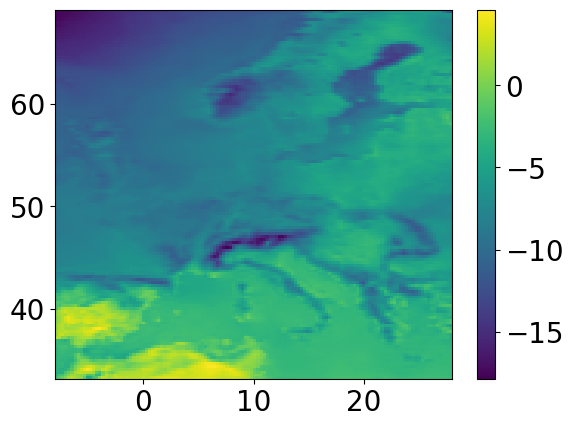

In [68]:
plt.pcolormesh(lon,lat,ds_truth_dn.isel(time=150)['tas'])
plt.colorbar()

In [69]:
ds_truth_dn.max()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tas      float32 4B 14.07
    pr       float32 4B 166.5

In [46]:
lat

<xarray.DataArray 'lat' (y: 128, x: 128)> Size: 66kB
array([[68.99293 , 68.99293 , 68.99293 , ..., 68.99293 , 68.99293 , 68.99293 ],
       [68.7119  , 68.7119  , 68.7119  , ..., 68.7119  , 68.7119  , 68.7119  ],
       [68.43087 , 68.43087 , 68.43087 , ..., 68.43087 , 68.43087 , 68.43087 ],
       ...,
       [33.86416 , 33.86416 , 33.86416 , ..., 33.86416 , 33.86416 , 33.86416 ],
       [33.583126, 33.583126, 33.583126, ..., 33.583126, 33.583126, 33.583126],
       [33.302097, 33.302097, 33.302097, ..., 33.302097, 33.302097, 33.302097]],
      dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    standard_name:  latitude
    units:          degrees_north

In [ ]:
ds_truth*

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    tas      float32 4B 2.612
    pr       float32 4B 38.41

In [22]:
axes.shape

(4,)

In [16]:
date_strings

['01-Jan',
 '02-Jan',
 '03-Jan',
 '04-Jan',
 '05-Jan',
 '06-Jan',
 '07-Jan',
 '08-Jan',
 '09-Jan',
 '10-Jan',
 '11-Jan',
 '12-Jan',
 '13-Jan',
 '14-Jan',
 '15-Jan',
 '16-Jan',
 '17-Jan',
 '18-Jan',
 '19-Jan',
 '20-Jan',
 '21-Jan',
 '22-Jan',
 '23-Jan',
 '24-Jan',
 '25-Jan',
 '26-Jan',
 '27-Jan',
 '28-Jan',
 '29-Jan',
 '30-Jan',
 '31-Jan',
 '01-Feb',
 '02-Feb',
 '03-Feb',
 '04-Feb',
 '05-Feb',
 '06-Feb',
 '07-Feb',
 '08-Feb',
 '09-Feb',
 '10-Feb',
 '11-Feb',
 '12-Feb',
 '13-Feb',
 '14-Feb',
 '15-Feb',
 '16-Feb',
 '17-Feb',
 '18-Feb',
 '19-Feb',
 '20-Feb',
 '21-Feb',
 '22-Feb',
 '23-Feb',
 '24-Feb',
 '25-Feb',
 '26-Feb',
 '27-Feb',
 '28-Feb',
 '01-Mar',
 '02-Mar',
 '03-Mar',
 '04-Mar',
 '05-Mar',
 '06-Mar',
 '07-Mar',
 '08-Mar',
 '09-Mar',
 '10-Mar',
 '11-Mar',
 '12-Mar',
 '13-Mar',
 '14-Mar',
 '15-Mar',
 '16-Mar',
 '17-Mar',
 '18-Mar',
 '19-Mar',
 '20-Mar',
 '21-Mar',
 '22-Mar',
 '23-Mar',
 '24-Mar',
 '25-Mar',
 '26-Mar',
 '27-Mar',
 '28-Mar',
 '29-Mar',
 '30-Mar',
 '31-Mar',
 '01-Apr',

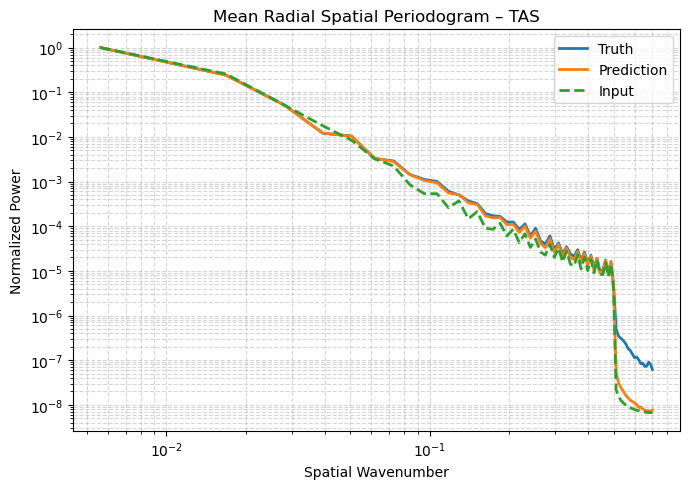

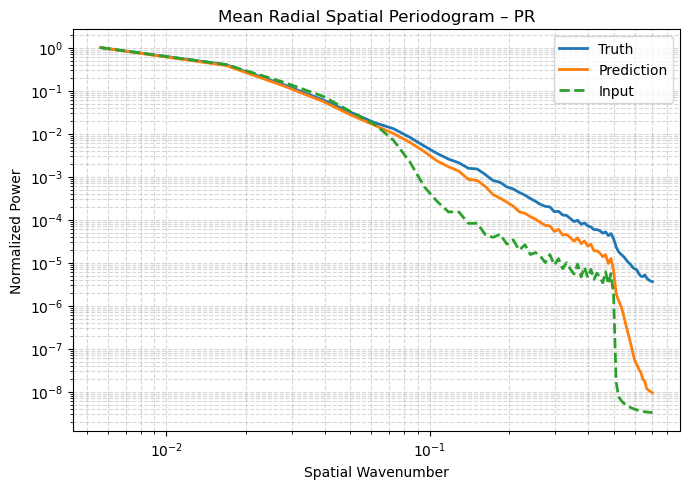

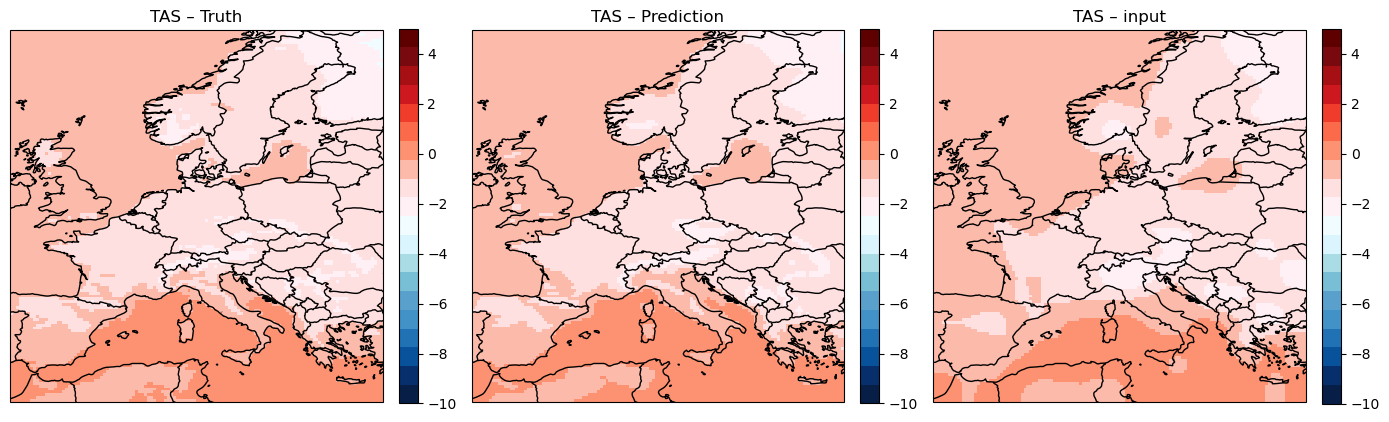

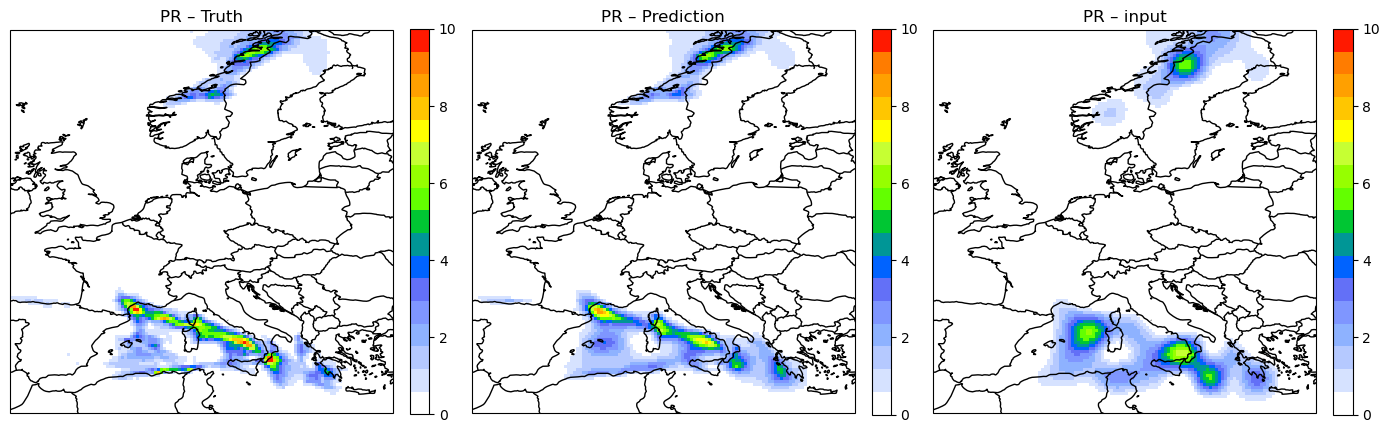

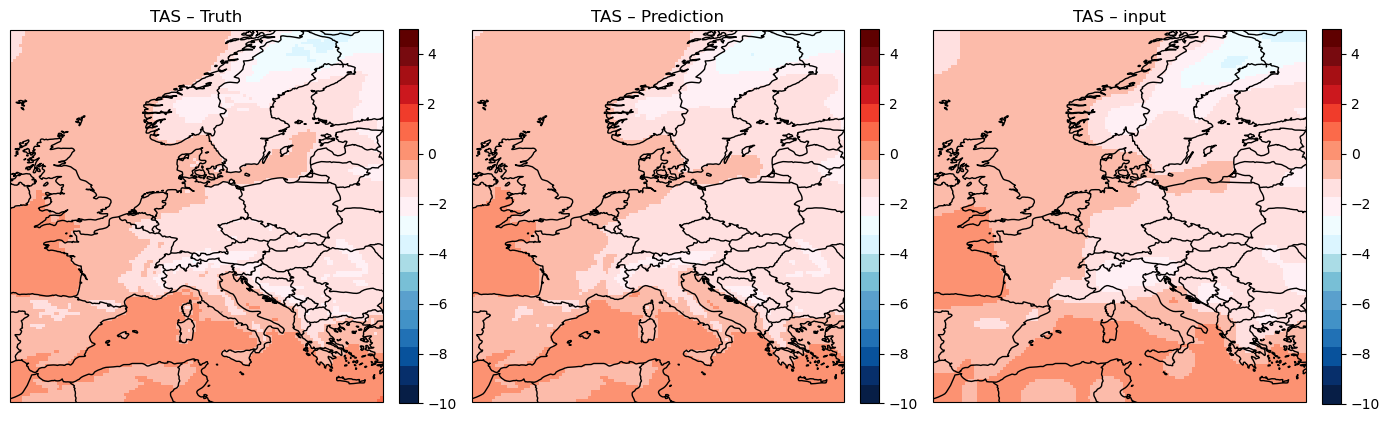

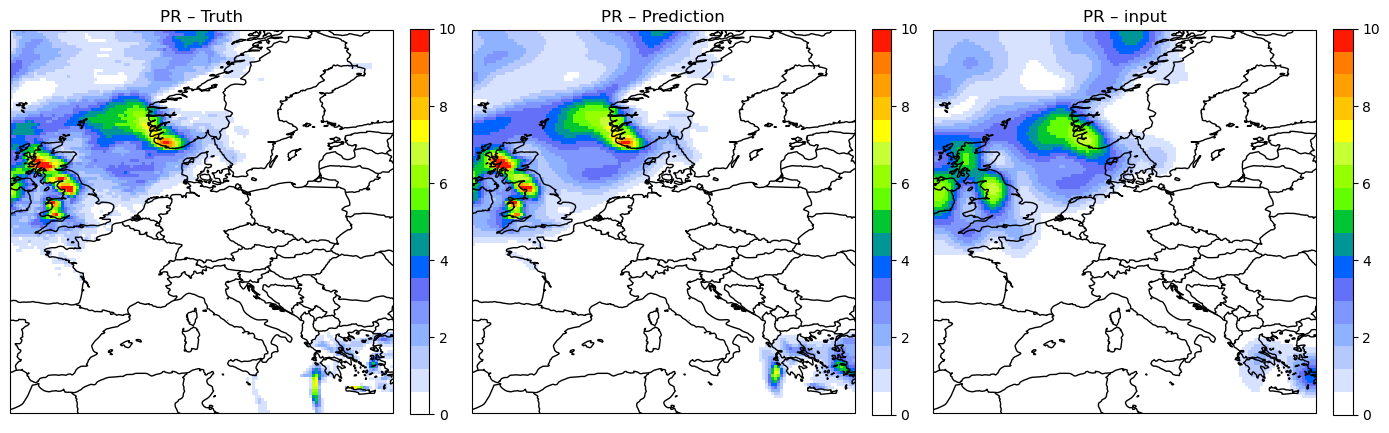

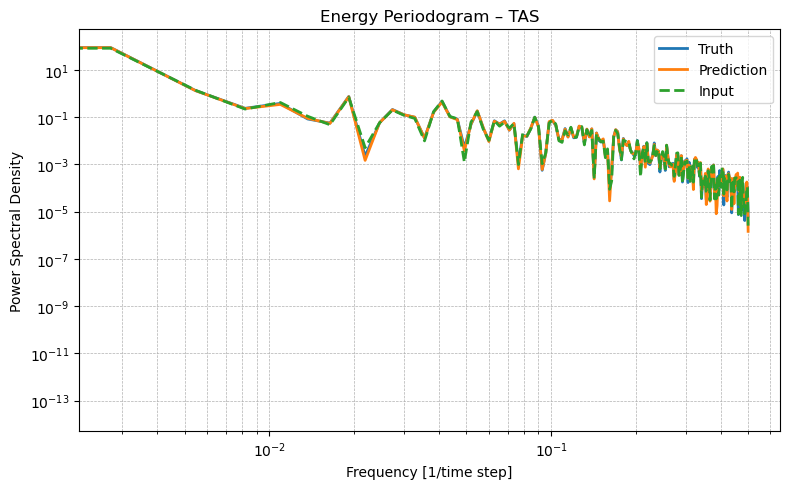

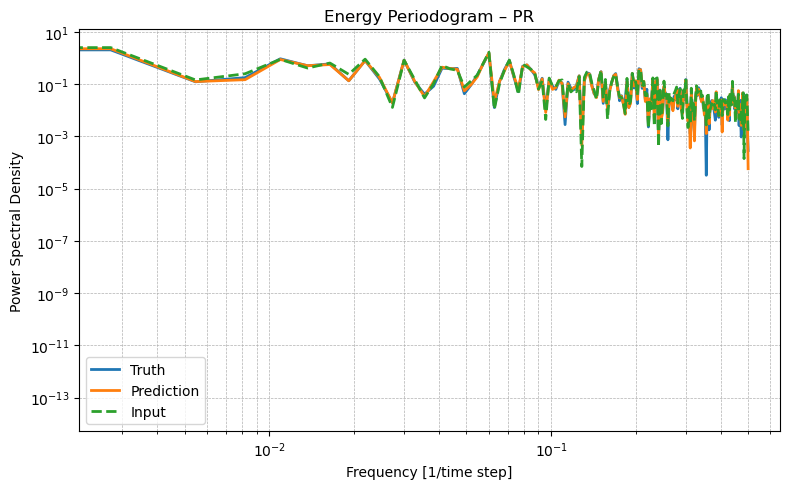

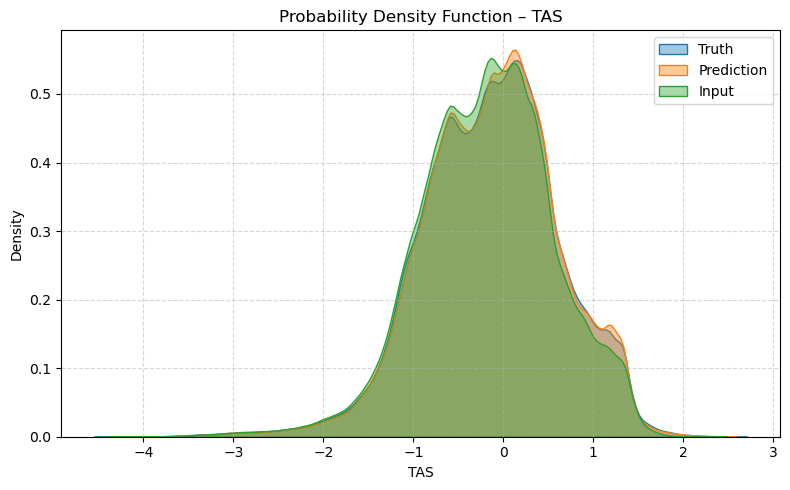

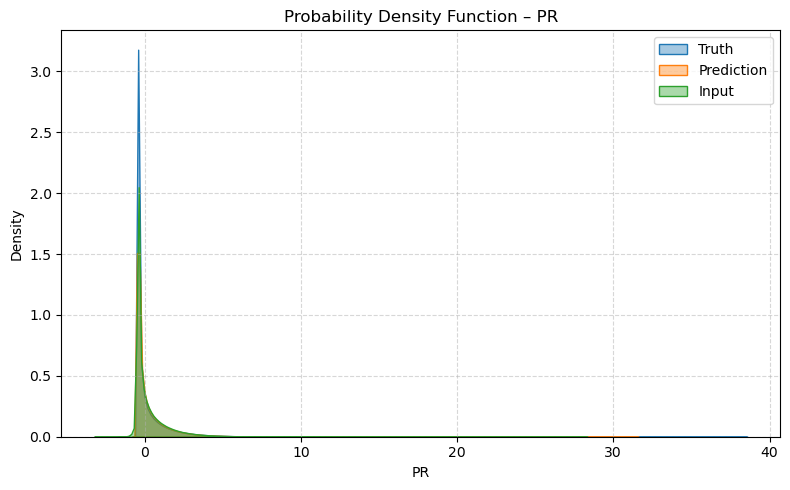

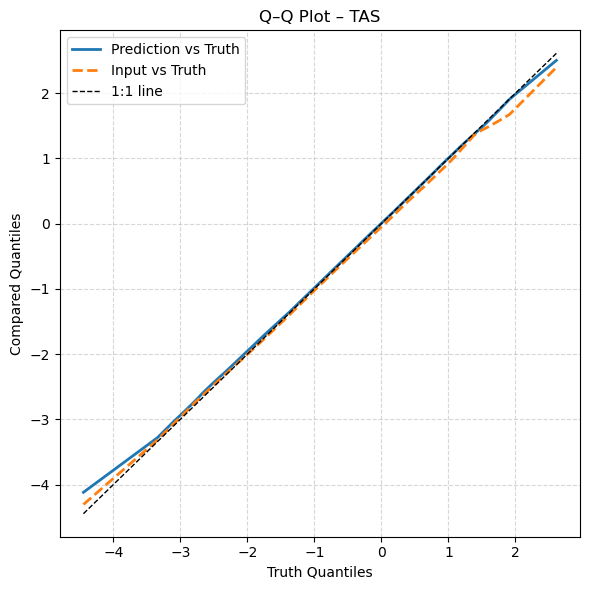

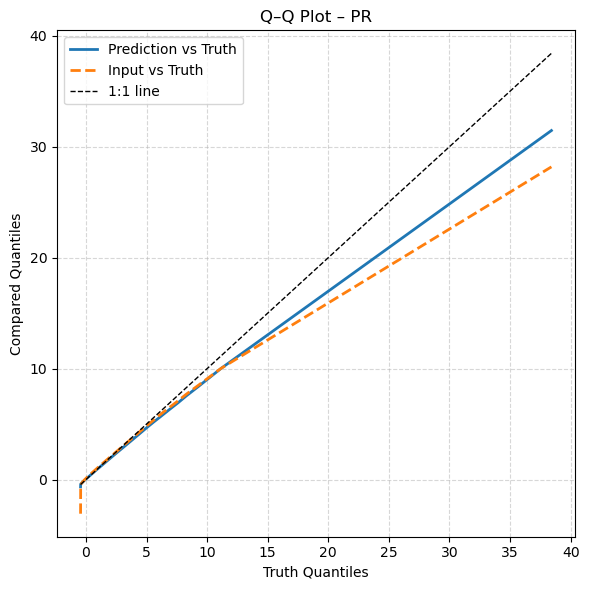

In [45]:
import json
# import holoviews as hv
# import hvplot.xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
# import jupyter_bokeh
# jupyter_bokeh.enable_notebook()
# hv.extension('bokeh')

# --- Open datasets ---
# filename = "corrdiff_output_2024.nc"
filename = "outputs/corrdiff_output_2024.nc"
ds_inv = xr.open_dataset(filename)
ds_truth = xr.open_dataset(filename, group="truth", decode_times=True)
ds_pred = xr.open_dataset(filename, group="prediction", decode_times=True)
ds_input = xr.open_dataset(filename, group="input", decode_times=True)
# ds_input['tas'] = ds_input['tas']-273
# --- Assign 2D lat/lon coordinates and time ---
coords = {'lat': (('y','x'), ds_inv['lat'].values),
          'lon': (('y','x'), ds_inv['lon'].values),
          'time': ds_inv['time'].values}

ds_truth = ds_truth.assign_coords(coords)
ds_pred = ds_pred.assign_coords(coords)



ds_truth_dn = ds_truth
ds_pred_dn = ds_pred

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import colormaps as cmaps
from scipy.signal import periodogram
import seaborn as sns

# Example for first time step
time0 = ds_truth_dn.time.values[0]
plot_settings = {
    "tas": {"vmin": -10, "vmax": 5, "cmap": cmaps.temp_19lev},
    "pr":  {"vmin": 0, "vmax": 10, "cmap": cmaps.precip3_16lev},
}

def plot_side_by_side(var, time_idx=0):
    fig, axes = plt.subplots(1, 3, figsize=(14, 6),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Get data for the time step
    z_truth = ds_truth_dn[var].isel(time=time_idx).values.squeeze()
    z_input = ds_input[var].isel(time=time_idx).values.squeeze()
    z_pred  = ds_pred_dn[var].isel(time=time_idx,ensemble=0).values.squeeze()
    lon = ds_truth_dn['lon'].values
    lat = ds_truth_dn['lat'].values
    
    # Plot Truth
    im1 = axes[0].pcolormesh(
        lon, lat, z_truth,
        cmap=plot_settings[var]["cmap"],
        vmin=plot_settings[var]["vmin"],
        vmax=plot_settings[var]["vmax"],
        transform=ccrs.PlateCarree()
    )



    axes[0].coastlines()
    axes[0].add_feature(cfeature.BORDERS)
    axes[0].set_title(f"{var.upper()} – Truth")
    fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
    
    # Plot Prediction
    im2 = axes[1].pcolormesh(
        lon, lat, z_pred,
        cmap=plot_settings[var]["cmap"],
        vmin=plot_settings[var]["vmin"],
        vmax=plot_settings[var]["vmax"],
        transform=ccrs.PlateCarree()
    )
    axes[1].coastlines()
    axes[1].add_feature(cfeature.BORDERS)
    axes[1].set_title(f"{var.upper()} – Prediction")
    fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
    
    # Plot Prediction
    im3 = axes[2].pcolormesh(
        lon, lat, z_input,
        cmap=plot_settings[var]["cmap"],
        vmin=plot_settings[var]["vmin"],
        vmax=plot_settings[var]["vmax"],
        transform=ccrs.PlateCarree()
    )
    axes[2].coastlines()
    axes[2].add_feature(cfeature.BORDERS)
    axes[2].set_title(f"{var.upper()} – input")
    fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
    

    plt.tight_layout()
    plt.show()
def plot_energy_periodogram(ds_truth, ds_pred, ds_input, var, fs=1.0):
    """
    Compute and plot the energy periodogram (power spectral density)
    for a variable spatially averaged over the domain.

    Parameters
    ----------
    ds_truth, ds_pred, ds_input : xarray.Dataset
        Datasets containing the variable (e.g., 'tas' or 'pr').
    var : str
        Variable name.
    fs : float, optional
        Sampling frequency (e.g., 1/day if daily data).
    """
    # Spatial mean
    truth_series = ds_truth[var].mean(dim=("x", "y")).values.squeeze()
    pred_series = ds_pred[var].mean(dim=("x", "y", "ensemble")).values.squeeze()
    input_series = ds_input[var].mean(dim=("x", "y")).values.squeeze()

    # Compute periodograms
    f_truth, p_truth = periodogram(truth_series, fs=fs)
    f_pred, p_pred = periodogram(pred_series, fs=fs)
    f_input, p_input = periodogram(input_series, fs=fs)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.loglog(f_truth, p_truth, label='Truth', lw=2)
    plt.loglog(f_pred, p_pred, label='Prediction', lw=2)
    plt.loglog(f_input, p_input, label='Input', lw=2, linestyle='--')
    plt.xlabel('Frequency [1/time step]')
    plt.ylabel('Power Spectral Density')
    plt.title(f'Energy Periodogram – {var.upper()}')
    # plt.ylim([1e-1,1e3])
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()
def radial_spectrum(field2d):
    """
    Compute the 1D (radially averaged) power spectrum of a 2D field.

    Parameters
    ----------
    field2d : 2D np.ndarray
        Input spatial field (e.g., precipitation or temperature for one timestep).

    Returns
    -------
    k_bins : 1D np.ndarray
        Radial wavenumber bins.
    psd_1d : 1D np.ndarray
        Azimuthally averaged power spectral density.
    """
    # Remove mean and NaNs
    field = np.nan_to_num(field2d - np.nanmean(field2d))

    # 2D FFT
    F = np.fft.fftshift(np.fft.fft2(field))
    psd2d = np.abs(F)**2

    # Coordinate grids
    ny, nx = field.shape
    ky = np.fft.fftshift(np.fft.fftfreq(ny))
    kx = np.fft.fftshift(np.fft.fftfreq(nx))
    KX, KY = np.meshgrid(kx, ky)
    KR = np.sqrt(KX**2 + KY**2)

    # Radial binning
    k_bins = np.linspace(0, np.max(KR), min(nx, ny)//2)
    psd_1d = np.zeros_like(k_bins[:-1])
    for i in range(len(k_bins)-1):
        mask = (KR >= k_bins[i]) & (KR < k_bins[i+1])
        psd_1d[i] = np.mean(psd2d[mask]) if np.any(mask) else np.nan

    k_mid = 0.5 * (k_bins[1:] + k_bins[:-1])
    return k_mid, psd_1d

def mean_radial_periodogram(ds, var, n_samples=10):
    idx = np.linspace(0, len(ds.time)-1, n_samples, dtype=int)
    spectra = []
    for i in idx:
        _, psd = radial_spectrum(ds[var].isel(time=i).values.squeeze())
        spectra.append(psd)
    return np.nanmean(spectra, axis=0)

# Example average version
def plot_mean_radial_periodogram(ds_truth, ds_pred, ds_input, var, n_samples=10):
    truth_mean = mean_radial_periodogram(ds_truth, var, n_samples)
    pred_mean = mean_radial_periodogram(ds_pred, var, n_samples)
    input_mean = mean_radial_periodogram(ds_input, var, n_samples)
    k, _ = radial_spectrum(ds_truth[var].isel(time=0).values.squeeze())

    plt.figure(figsize=(7,5))
    plt.loglog(k, truth_mean/truth_mean.max(), label='Truth', lw=2)
    plt.loglog(k, pred_mean/pred_mean.max(), label='Prediction', lw=2)
    plt.loglog(k, input_mean/input_mean.max(), label='Input', lw=2, linestyle='--')
    plt.xlabel('Spatial Wavenumber')
    plt.ylabel('Normalized Power')
    plt.title(f'Mean Radial Spatial Periodogram – {var.upper()}')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_mean_radial_periodogram(ds_truth, ds_pred.isel(ensemble=0), ds_input, 'tas', n_samples=10)
plot_mean_radial_periodogram(ds_truth, ds_pred.isel(ensemble=0), ds_input, 'pr', n_samples=10)

def plot_pdf_comparison(ds_truth, ds_pred, ds_input, var, bins=50):
    """
    Plot probability density functions (PDFs) of truth, prediction, and input.

    Parameters
    ----------
    ds_truth, ds_pred, ds_input : xarray.Dataset
        Datasets containing the variable (e.g., 'tas' or 'pr').
    var : str
        Variable name.
    bins : int, optional
        Number of bins for the histogram/PDF.
    """
    truth_vals = ds_truth[var].values.flatten()
    pred_vals = ds_pred[var].isel(ensemble=0).values.flatten()
    input_vals = ds_input[var].values.flatten()

    # Drop NaNs
    truth_vals = truth_vals[~np.isnan(truth_vals)]
    pred_vals = pred_vals[~np.isnan(pred_vals)]
    input_vals = input_vals[~np.isnan(input_vals)]

    # Plot PDFs
    plt.figure(figsize=(8, 5))
    sns.kdeplot(truth_vals, label='Truth', fill=True, alpha=0.4)
    sns.kdeplot(pred_vals, label='Prediction', fill=True, alpha=0.4)
    sns.kdeplot(input_vals, label='Input', fill=True, alpha=0.4)
    plt.title(f'Probability Density Function – {var.upper()}')
    plt.xlabel(var.upper())
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Example usage
plot_side_by_side('tas', time_idx=10)
plot_side_by_side('pr', time_idx=10)

plot_side_by_side('tas', time_idx=20)
plot_side_by_side('pr', time_idx=20)

plot_energy_periodogram(ds_truth_dn, ds_pred_dn, ds_input, var='tas', fs=1.0)
plot_energy_periodogram(ds_truth_dn, ds_pred_dn, ds_input, var='pr', fs=1.0)

plot_pdf_comparison(ds_truth_dn, ds_pred_dn, ds_input, var='tas')
plot_pdf_comparison(ds_truth_dn, ds_pred_dn, ds_input, var='pr')

def plot_qq_comparison(ds_truth, ds_pred, ds_input, var, n_quantiles=1000):
    """
    Plot Q–Q plots comparing prediction and input distributions against truth.

    Parameters
    ----------
    ds_truth, ds_pred, ds_input : xarray.Dataset
        Datasets containing the variable (e.g., 'tas' or 'pr').
    var : str
        Variable name.
    n_quantiles : int, optional
        Number of quantile points for comparison.
    """
    truth_vals = ds_truth[var].values.flatten()
    pred_vals = ds_pred[var].isel(ensemble=0).values.flatten()
    input_vals = ds_input[var].values.flatten()

    # Remove NaNs
    truth_vals = truth_vals[~np.isnan(truth_vals)]
    pred_vals = pred_vals[~np.isnan(pred_vals)]
    input_vals = input_vals[~np.isnan(input_vals)]

    # Compute quantiles
    q = np.linspace(0, 1, n_quantiles)
    truth_q = np.quantile(truth_vals, q)
    pred_q = np.quantile(pred_vals, q)
    input_q = np.quantile(input_vals, q)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(truth_q, pred_q, label='Prediction vs Truth', lw=2)
    plt.plot(truth_q, input_q, label='Input vs Truth', lw=2, linestyle='--')
    plt.plot(truth_q, truth_q, 'k--', lw=1, label='1:1 line')

    plt.xlabel('Truth Quantiles')
    plt.ylabel('Compared Quantiles')
    plt.title(f'Q–Q Plot – {var.upper()}')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_qq_comparison(ds_truth_dn, ds_pred_dn, ds_input, var='tas')
plot_qq_comparison(ds_truth_dn, ds_pred_dn, ds_input, var='pr')    


0.05
0.14400000000000002
0.238
0.332
0.426
0.52
0.6140000000000001
0.7080000000000001
0.802
0.896
0.99


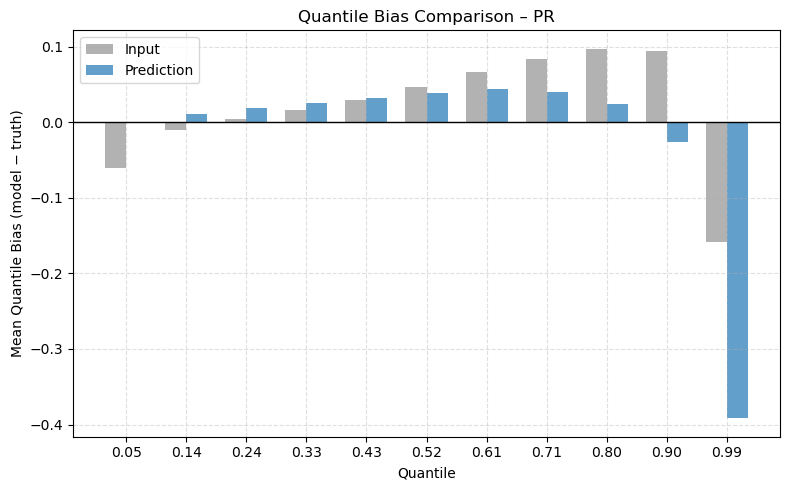

0.05
0.14400000000000002
0.238
0.332
0.426
0.52
0.6140000000000001
0.7080000000000001
0.802
0.896
0.99


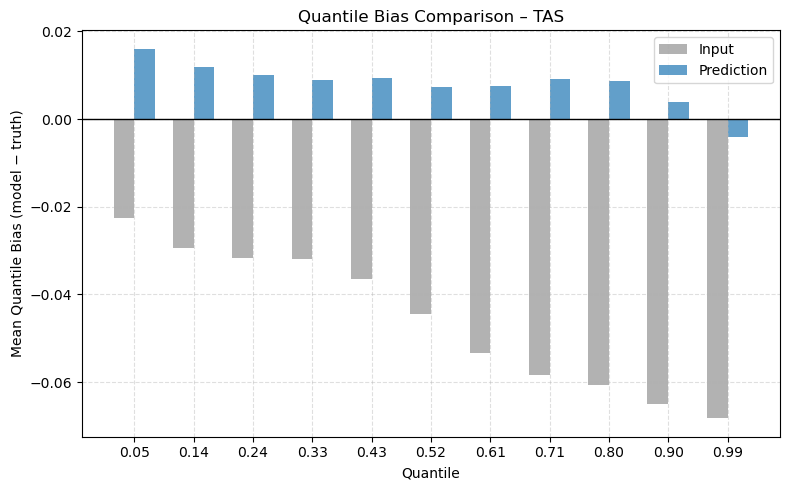

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

def quantile_bias_map(ds_truth, ds_model, var, q):
    """
    Compute spatial map of bias in the q-th quantile of `var`.
    """
    qt = ds_truth[var].quantile(q,dim="time")
    qm = ds_model[var].quantile(q,dim="time")
    return (qm - qt).mean()  # positive → model overestimates that quantile


def quantile_bias_summary(ds_truth, ds_pred, ds_input, var, quantiles=None):
    """
    Compute mean quantile bias (over space) for input and prediction.

    Returns
    -------
    qvals : list of quantiles
    mean_bias_input : list
    mean_bias_pred : list
    """
    if quantiles is None:
        quantiles = np.linspace(0.05, 0.99, 11)  # 5th → 99th percentiles

    mean_bias_input = []
    mean_bias_pred = []

    for q in quantiles:
        print(q)
        bias_in = quantile_bias_map(ds_truth, ds_input, var, q).mean().item()
        bias_pr = quantile_bias_map(ds_truth, ds_pred, var, q).mean().item()
        mean_bias_input.append(bias_in)
        mean_bias_pred.append(bias_pr)

    return quantiles, mean_bias_input, mean_bias_pred


def plot_quantile_bias_bars(quantiles, bias_input, bias_pred, var):
    """
    Plot mean quantile biases for input and prediction.
    """
    x = np.arange(len(quantiles))
    width = 0.35

    plt.figure(figsize=(8,5))
    plt.bar(x - width/2, bias_input, width, label='Input', color='tab:gray', alpha=0.6)
    plt.bar(x + width/2, bias_pred, width, label='Prediction', color='tab:blue', alpha=0.7)

    plt.axhline(0, color='k', lw=1)
    plt.xticks(x, [f"{q:.2f}" for q in quantiles])
    plt.xlabel('Quantile')
    plt.ylabel('Mean Quantile Bias (model − truth)')
    plt.title(f'Quantile Bias Comparison – {var.upper()}')
    plt.legend()
    plt.grid(True, ls='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# === Example usage ===
quantiles, bias_input, bias_pred = quantile_bias_summary(ds_truth_dn, ds_pred_dn, ds_input, 'pr')
plot_quantile_bias_bars(quantiles, bias_input, bias_pred, 'pr')

quantiles, bias_input, bias_pred = quantile_bias_summary(ds_truth_dn, ds_pred_dn, ds_input, 'tas')
plot_quantile_bias_bars(quantiles, bias_input, bias_pred, 'tas')


In [6]:
from vis.diagnostics import (denormalize_ds, variable_diagnostics)
import xarray as xr
# open your datasets (as in your snippet)
ds_inv = xr.open_dataset("unet_era5_2024.nc")
ds_truth = xr.open_dataset("unet_era5_2024.nc", group="truth", decode_times=True)
ds_pred = xr.open_dataset("unet_era5_2024.nc", group="prediction", decode_times=True)

ds_truth = ds_truth.assign_coords(
    time=ds_inv['time'],
    lat=(('y'), ds_inv['lat'].data[:,0]),
    lon=(('x'), ds_inv['lon'].data[0,:])
).rename({'y': 'lat', 'x': 'lon'})

ds_pred = ds_pred.assign_coords(
    time=ds_inv['time'],
    lat=(('y'), ds_inv['lat'].data[:,0]),
    lon=(('x'), ds_inv['lon'].data[0,:])
).rename({'y': 'lat', 'x': 'lon'})

# load stats
# import json
# with open("/beegfs/muduchuru/data/mswx/mswx_stats.json") as f:
#     stats = json.load(f)

# # If your data are normalized, denormalize (function handles it inside variable_diagnostics)
# out = variable_diagnostics(
#     ds_truth,
#     ds_pred,
#     var="tas",
#     stats=stats,
#     denormalize=True,
#     ensemble="mean",
#     monthly_agg="mean",
#     outdir="./diag_out",
#     save_pdf=True,
#     make_spatial_examples=True
# )
# # Look at daily metrics (pandas)
# print(out["daily_metrics"].head())

# Figures saved under ./diagnostics_out/ or returned as mpl.Figure


/tmp/ipykernel_1124127/1131887447.py:12: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})
/tmp/ipykernel_1124127/1131887447.py:12: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})
/tmp/ipykernel_1124127/1131887447.py:18: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})
/tmp/ipykernel_1124127/1131887447.py:18: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})


/tmp/ipykernel_1125805/1832962211.py:19: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})
/tmp/ipykernel_1125805/1832962211.py:19: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'})
/tmp/ipykernel_1125805/1832962211.py:25: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'}).isel(ensemble=0)
/tmp/ipykernel_1125805/1832962211.py:25: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ).rename({'y': 'lat', 'x': 'lon'}).isel(ensemble=0)


Worst time: 2021-08-05T00:00:00.000000000


NameError: name 'worst_y' is not defined

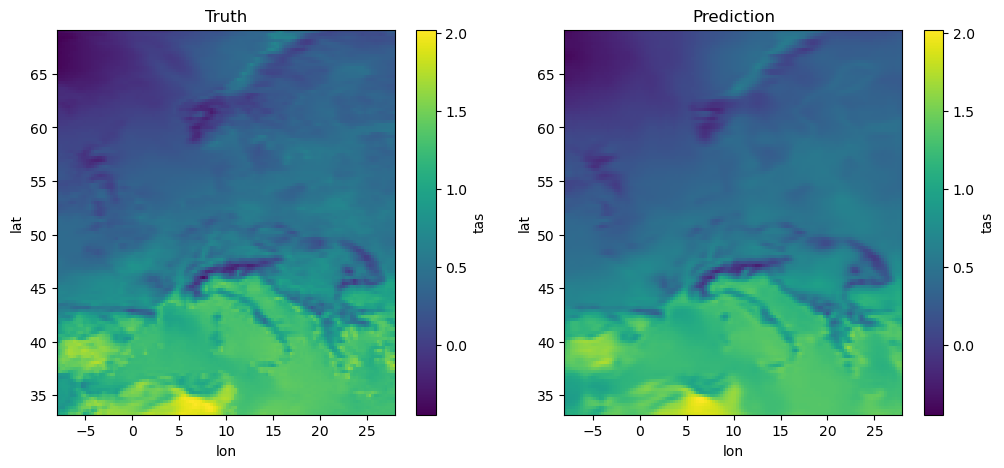

In [8]:
import xskillscore as xs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from vis.diagnostics import (denormalize_ds, variable_diagnostics)
import xarray as xr
# open your datasets (as in your snippet)
ds_inv = xr.open_dataset("unet_era5_2024.nc")
ds_truth = xr.open_dataset("unet_era5_2024.nc", group="truth", decode_times=True)
ds_pred = xr.open_dataset("unet_era5_2024.nc", group="prediction", decode_times=True)

var = "tas"  # change if needed


ds_truth = ds_truth.assign_coords(
    time=ds_inv['time'],
    lat=(('y'), ds_inv['lat'].data[:,0]),
    lon=(('x'), ds_inv['lon'].data[0,:])
).rename({'y': 'lat', 'x': 'lon'})

ds_pred = ds_pred.assign_coords(
    time=ds_inv['time'],
    lat=(('y'), ds_inv['lat'].data[:,0]),
    lon=(('x'), ds_inv['lon'].data[0,:])
).rename({'y': 'lat', 'x': 'lon'}).isel(ensemble=0)

# ✅ Ensure dims consistent
ds_pred = ds_pred.transpose("time", "lat", "lon")
ds_truth = ds_truth.transpose("time", "lat", "lon")

# ✅ MAPE & MAE over time (OK because no zeros aggregation)
mae_time = xs.mae(ds_pred[var], ds_truth[var], dim="time")  # (lat, lon)
mape_time = xs.mape(ds_pred[var], ds_truth[var], dim="time")  # (lat, lon)

# ✅ Manual spatial reduction → avoids xskillscore bug
abs_err = np.abs(ds_pred[var] - ds_truth[var])
mae_xy = abs_err.mean(dim=("lat", "lon"))  # (time,)

mape_xy = (abs_err / (ds_truth[var] + 1e-6) * 100).mean(dim=("lat", "lon"))  # (time,)
mape_xy = mape_xy.clip(max=1000)  # avoid huge spikes

# ✅ Find worst pixel (max spatial-mean error)
worst_time = mape_xy.time[mape_xy.argmax()].values
print("Worst time:", worst_time)

# # ✅ Find worst pixel location at that time
# mape_frame = mape_time.sel(time=worst_time)
# worst_y, worst_x = np.unravel_index(np.argmax(mape_frame.values),
#                                     mape_frame.shape)
# print(f"Worst location -> lat_index={worst_y}, lon_index={worst_x}")

# ✅ Plot spatial map
truth_map = ds_truth[var].sel(time=worst_time)
pred_map = ds_pred[var].sel(time=worst_time)

vmin = float(min(truth_map.min(), pred_map.min()))
vmax = float(max(truth_map.max(), pred_map.max()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
truth_map.plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap="viridis")
axes[0].set_title("Truth")

pred_map.plot(ax=axes[1], vmin=vmin, vmax=vmax, cmap="viridis")
axes[1].set_title("Prediction")

plt.suptitle(f"Time={str(worst_time)[:10]} | Worst pixel (lat={worst_y}, lon={worst_x})")
plt.tight_layout()
plt.show()

# ✅ Time series at worst pixel
plt.figure(figsize=(12,4))
ds_truth[var].isel(lat=worst_y, lon=worst_x).plot(label="Truth")
ds_pred[var].isel(lat=worst_y, lon=worst_x).plot(label="Pred", linestyle="--")
plt.legend()
plt.title(f"Time Series at Worst Pixel — {var.upper()}")
plt.show()


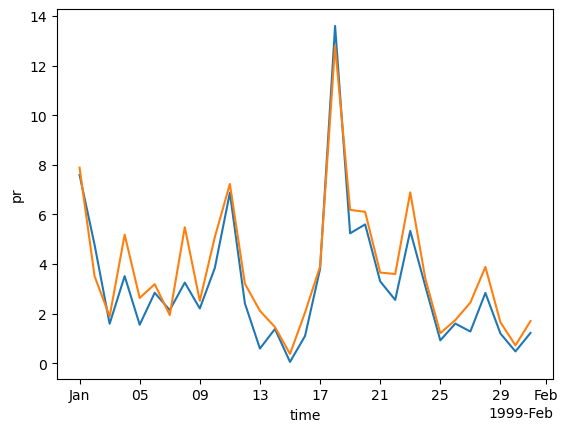

In [10]:
ds_truth.mean(["x","y"])['pr'].sel().plot()
ds_pred_dn.mean(["x","y"])['pr'].plot()

In [2]:
ds_truth_dn

<xarray.Dataset> Size: 48MB
Dimensions:  (time: 366, y: 128, x: 128)
Coordinates:
    lat      (y, x) float32 66kB 44.55 44.55 44.55 44.55 ... 57.25 57.25 57.25
    lon      (y, x) float32 66kB 3.55 3.65 3.75 3.85 ... 15.95 16.05 16.15 16.25
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2022-01-01
Dimensions without coordinates: y, x
Data variables:
    tas      (time, y, x) float32 24MB ...
    pr       (time, y, x) float32 24MB ...

reading stats_era5
reading stats_mswx


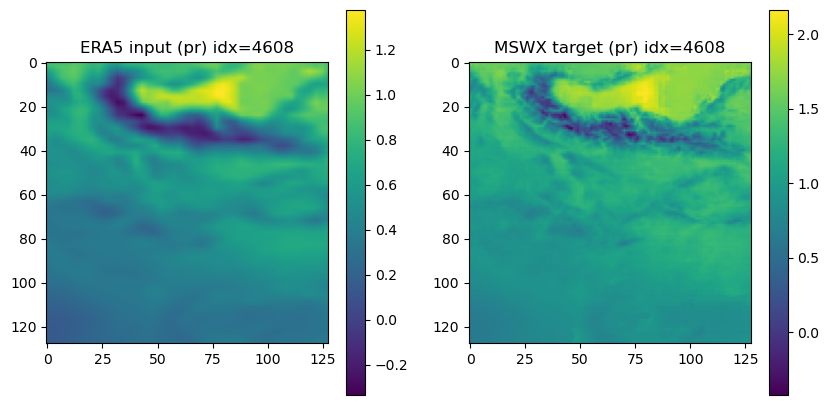

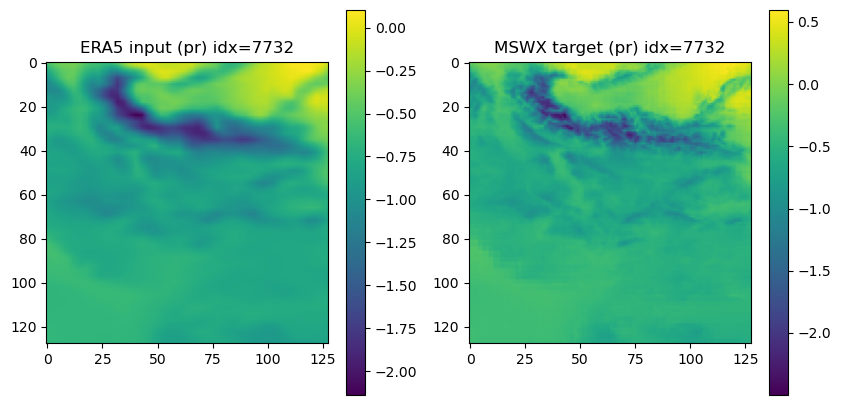

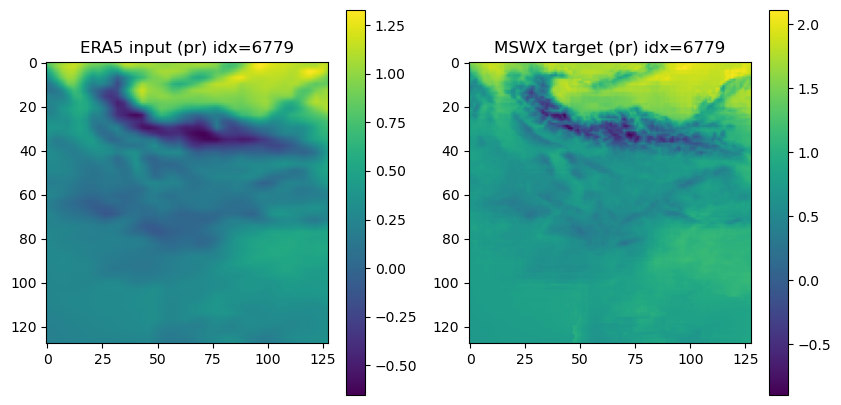

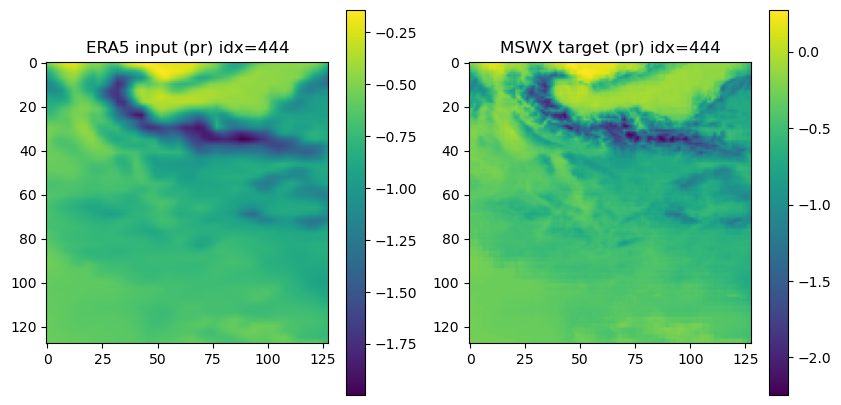

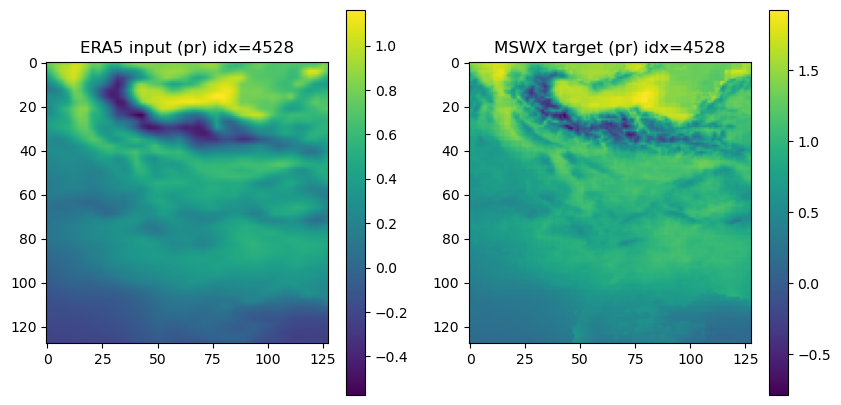

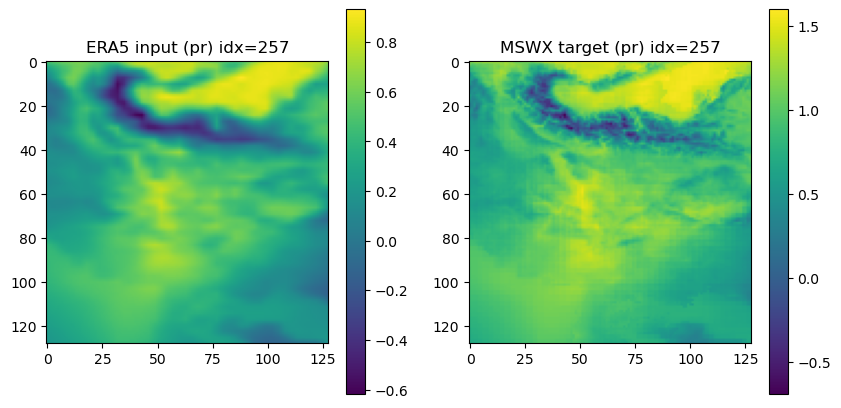

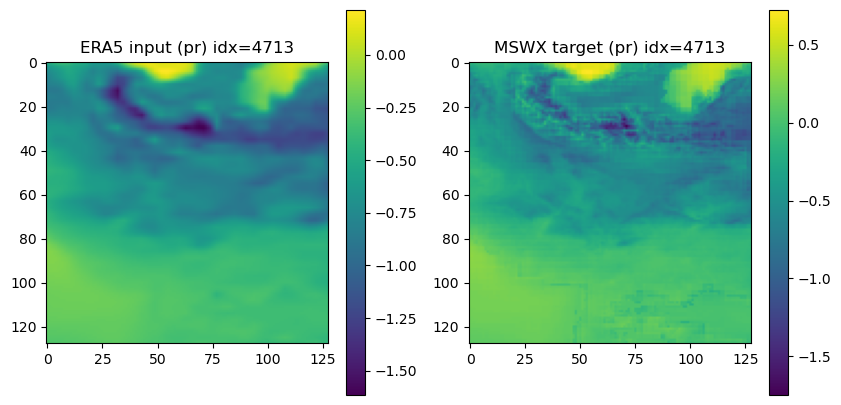

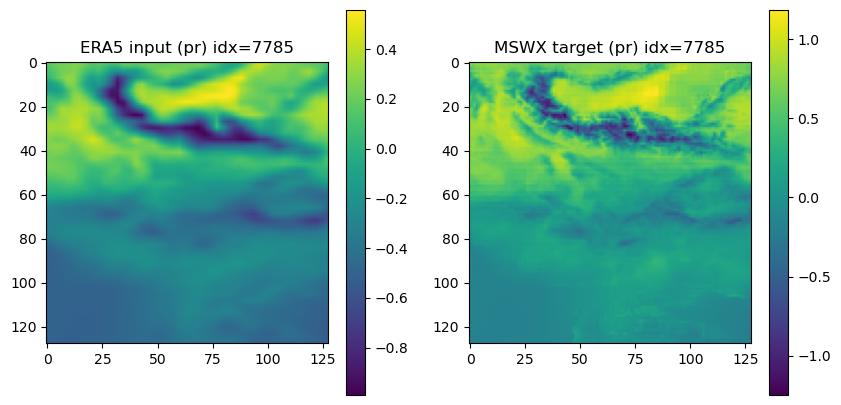

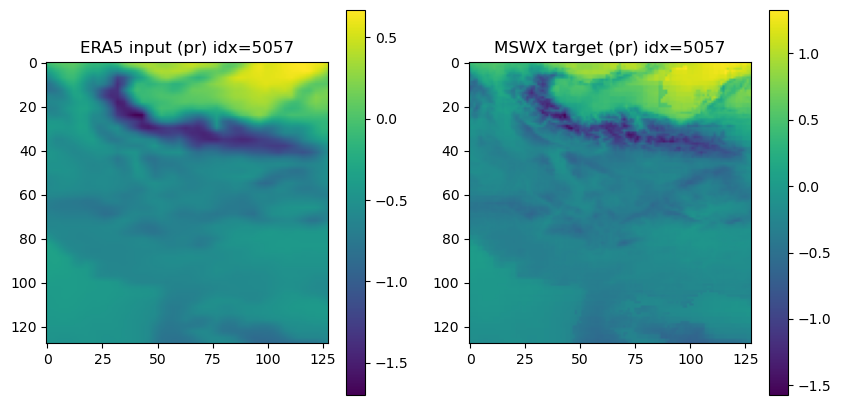

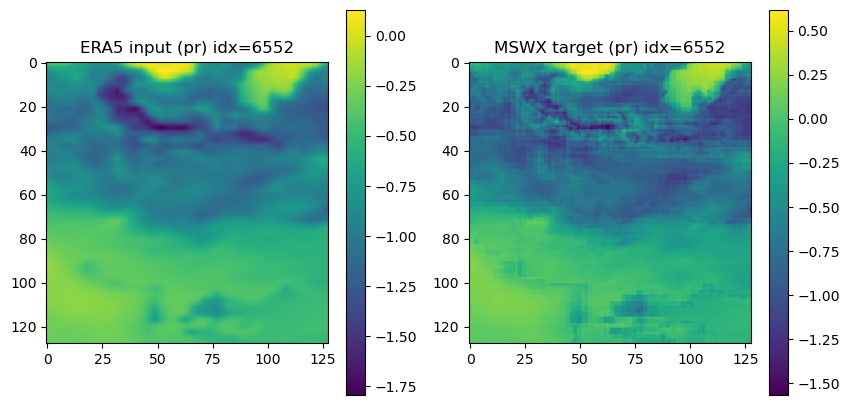

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
# import sys
# sys.path.append("/beegfs/muduchuru/codes/physicsnemo/examples/weather/corrdiff/")
from datasets.era5_mswx import era5_mswx
# Initialize your dataset
data_path = "/beegfs/muduchuru/data/"  # replace with your actual path
input_channels = ["pr","tas"]  # example input channels
output_channels = ["pr","tas"]  # target channel

dataset = era5_mswx(
    data_path=data_path,
    stats_era5="/beegfs/muduchuru/data/era5/europe_stats.json",
    stats_mswx="/beegfs/muduchuru/data/mswx/mswx_stats.json",
    train=True,
    input_channels=input_channels,
    output_channels=output_channels,
    patch_size=(128, 128),
    center_latlon=(50.0, 10.0),  # for example
)

# Pick 10 random indices
random_indices = random.sample(range(len(dataset)), 10)

for idx in random_indices:
    output_arr, input_arr, lead_time_label = dataset[idx]
    
    pr_input = input_arr[1, :, :]  # (H, W)
    pr_output = output_arr[1, :, :]           # assuming output_channels=['pr']
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    im0 = axes[0].imshow(pr_input, cmap="viridis")
    axes[0].set_title(f"ERA5 input (pr) idx={idx}")
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(pr_output, cmap="viridis")
    axes[1].set_title(f"MSWX target (pr) idx={idx}")
    fig.colorbar(im1, ax=axes[1])
    
    plt.show()


In [4]:
import xskillscore as xs
import xarray as xr
import numpy as np

# Assume your variable name is 'precip' — adjust as needed
var_name = "pr"

truth = ds_truth[var_name]
pred = ds_pred[var_name]
# input_ = ds_input[var_name]

# -------------------------------------------------
# 1️⃣ Spatial metrics: reduce over lat/lon
# -------------------------------------------------
# RMSE across space for each time
rmse_space = xs.rmse(pred, truth, dim=["x", "y"])
corr_space = xs.pearson_r(pred, truth, dim=["x", "y"])

# print("RMSE over space (per time):")
# print(rmse_space)

print("Correlation over space (per time):")
print(corr_space)

# -------------------------------------------------
# 2️⃣ Temporal metrics: reduce over time
# -------------------------------------------------
# RMSE across time for each spatial point
rmse_time = xs.rmse(pred, truth, dim="time")
corr_time = xs.pearson_r(pred, truth, dim="time")

# print("RMSE over time (per grid point):")
# print(rmse_time)

print("Correlation over time (per grid point):")
print(corr_time)

# -------------------------------------------------
# 3️⃣ Global metrics (over all dims)
# -------------------------------------------------
rmse_global = xs.rmse(pred, truth, dim=["time","x", "y"])
corr_global = xs.pearson_r(pred, truth, dim=["time","x", "y"])

print(f"Global RMSE: {rmse_global.values}")
print(f"Global correlation: {corr_global.values}")



Correlation over space (per time):
<xarray.DataArray 'pr' (ensemble: 1, time: 366)> Size: 1kB
array([[ 6.10890090e-01,  6.48114011e-02,  8.40720534e-01,
         3.97632837e-01, -2.20914669e-02,  7.40126550e-01,
         4.98197526e-01,  8.07050884e-01,  6.74338400e-01,
         2.03812286e-01,  7.35134900e-01,  7.00764894e-01,
         3.38435709e-01,  6.82940722e-01,  6.29686654e-01,
         9.81953740e-02,  6.41629696e-01,  4.84474421e-01,
         5.94293714e-01,  5.72447360e-01,  8.20737839e-01,
         4.34232175e-01,  6.55612409e-01,  6.81274951e-01,
        -6.01433031e-03,  1.22764176e-02,  5.72274067e-02,
         4.29360062e-01,  7.43067145e-01,  5.78655481e-01,
        -1.17831293e-03,  4.28698987e-01,  6.64558530e-01,
         3.05254936e-01,  2.31747195e-01,  1.37755558e-01,
         1.02803566e-01,  7.88486779e-01,  4.45196122e-01,
         5.45754135e-01,  7.44252324e-01,  6.22382522e-01,
         7.25116372e-01,  3.79112363e-01,  4.73241568e-01,
         3.12105268e-

In [12]:
var = 'pr'
ds_pred_ts = ds_pred.mean(["x","y"])[var].squeeze()
ds_truth_ts = ds_truth.mean(["x","y"])[var].squeeze()
ds_pred_xy = ds_pred.mean(["time"])[var].squeeze()
ds_truth_xy = ds_truth.mean(["time"])[var].squeeze()

In [11]:
from scipy.signal import periodogram
def average_power_spectrum(data, d, axis):
    """
    Compute the average power spectrum of a 2D data array.

    This function calculates the power spectrum for each row of the input data and
    then averages them to obtain the overall power spectrum.
    The power spectrum represents the distribution of signal power as a function of frequency.

    Parameters:
        data (numpy.ndarray): 2D input data array.
        d (float): Sampling interval (time between data points).

    Returns:
        tuple: A tuple containing the frequency values and the average power spectrum.
        - freqs (numpy.ndarray): Frequency values corresponding to the power spectrum.
        - power_spectra (numpy.ndarray): Average power spectrum of the input data.
    """
    # Compute the power spectrum along the second dimension for each row
    freqs, power_spectra = periodogram(data, fs=1 / d, axis=axis)

    # Average along the first dimension
    while power_spectra.ndim > 1:
        power_spectra = power_spectra.mean(axis=0)

    return freqs, power_spectra

In [13]:
len(average_power_spectrum(ds_pred['pr'].squeeze(),d=10,axis=2))

2

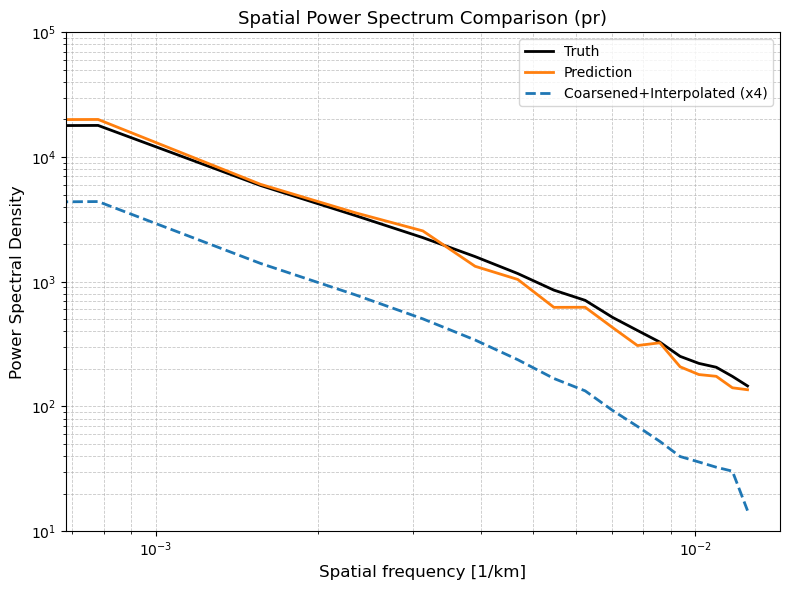

In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import periodogram

# --- Parameters ---
var = "pr"
fs = 1 / 10  # assuming 10 km grid spacing
coarsen_factor = 4

# --- Data ---
pred = ds_pred[var].squeeze()
truth = ds_truth[var].squeeze()

# --- Coarsen + Interpolate ---
truth_coarse = truth.coarsen(y=coarsen_factor, x=coarsen_factor, boundary="trim").mean()
truth_interp = truth_coarse.interp_like(truth)

# --- PSD Helper ---
def compute_spatial_psd(data, fs):
    data_np = np.nan_to_num(data.values)
    freq_x, psd_x = periodogram(data_np, fs=fs, axis=2)
    freq_y, psd_y = periodogram(data_np, fs=fs, axis=1)
    psd_sum = psd_x.mean(axis=(0, 1)) + psd_y.mean(axis=(0, 2))
    return freq_x, psd_sum

# --- Compute ---
freq_truth, psd_truth = compute_spatial_psd(truth, fs)
freq_pred, psd_pred = compute_spatial_psd(pred, fs)
freq_interp, psd_interp = compute_spatial_psd(truth_interp, fs)

# --- Align lengths just in case ---
min_len = min(len(freq_truth), len(psd_truth), len(freq_pred), len(psd_pred), len(psd_interp))
freq_truth = freq_truth[:min_len]
psd_truth = psd_truth[:min_len]
psd_pred = psd_pred[:min_len]
psd_interp = psd_interp[:min_len]

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.loglog(freq_truth, psd_truth, label="Truth", lw=2, color="black")
plt.loglog(freq_truth, psd_pred, label="Prediction", lw=2, color="tab:orange")
plt.loglog(freq_truth, psd_interp, label=f"Coarsened+Interpolated (x{coarsen_factor})", lw=2, color="tab:blue", ls="--")

plt.xlabel("Spatial frequency [1/km]", fontsize=12)
plt.ylabel("Power Spectral Density", fontsize=12)
plt.title(f"Spatial Power Spectrum Comparison ({var})", fontsize=13)
plt.legend()
plt.ylim([10**1,10**5])
plt.grid(True, which="both", ls="--", lw=0.6, alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
psd_sumfreq_x

array([0.        , 0.00078125, 0.0015625 , 0.00234375, 0.003125  ,
       0.00390625, 0.0046875 , 0.00546875, 0.00625   , 0.00703125,
       0.0078125 , 0.00859375, 0.009375  , 0.01015625, 0.0109375 ,
       0.01171875, 0.0125    , 0.01328125, 0.0140625 , 0.01484375,
       0.015625  , 0.01640625, 0.0171875 , 0.01796875, 0.01875   ,
       0.01953125, 0.0203125 , 0.02109375, 0.021875  , 0.02265625,
       0.0234375 , 0.02421875, 0.025     , 0.02578125, 0.0265625 ,
       0.02734375, 0.028125  , 0.02890625, 0.0296875 , 0.03046875,
       0.03125   , 0.03203125, 0.0328125 , 0.03359375, 0.034375  ,
       0.03515625, 0.0359375 , 0.03671875, 0.0375    , 0.03828125,
       0.0390625 , 0.03984375, 0.040625  , 0.04140625, 0.0421875 ,
       0.04296875, 0.04375   , 0.04453125, 0.0453125 , 0.04609375,
       0.046875  , 0.04765625, 0.0484375 , 0.04921875, 0.05      ])

In [ ]:
fre


=== Coarsening factor 1x ===
Global Pearson correlation: 0.357

=== Coarsening factor 2x ===
Global Pearson correlation: 0.376

=== Coarsening factor 4x ===
Global Pearson correlation: 0.397

=== Coarsening factor 8x ===
Global Pearson correlation: 0.431


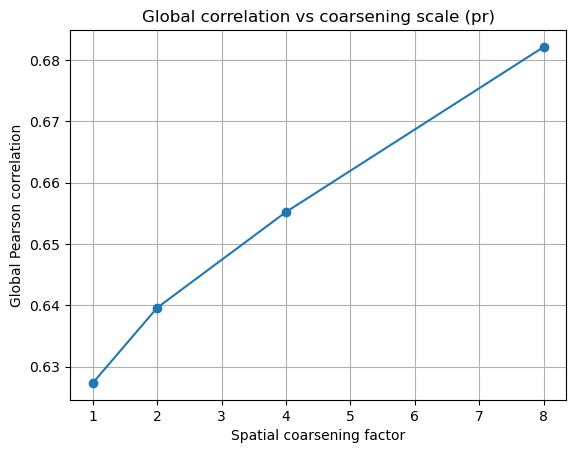

In [52]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt

# Variable name
var_name = "pr"
ds_truth_var = ds_truth[var_name]
ds_pred_var = ds_pred[var_name]

# Coarsening factors
factors = [1, 2, 4, 8]

# Store results
results = {}

for f in factors:
    print(f"\n=== Coarsening factor {f}x ===")
    
    # Coarsen spatially by averaging over x and y
    truth_coarse = ds_truth_var.coarsen(x=f, y=f, boundary="trim").mean()
    pred_coarse = ds_pred_var.coarsen(x=f, y=f, boundary="trim").mean()
    
    # Compute correlations
    corr_space = xs.pearson_r(pred_coarse, truth_coarse, dim=["x", "y"])   # correlation over space for each time
    corr_time = xs.pearson_r(pred_coarse, truth_coarse, dim="time")        # correlation over time per grid
    corr_global = xs.pearson_r(pred_coarse, truth_coarse, dim=["time", "x", "y"])  # global correlation

    # Store in dict
    results[f] = {
        "corr_space": corr_space,
        "corr_time": corr_time,
        "corr_global": corr_global
    }

    print(f"Global Pearson correlation: {corr_space.mean().values:.3f}")

# --- Plot correlation vs coarsening factor ---
corr_vals = [results[f]["corr_global"].values for f in factors]
plt.plot(factors, corr_vals, marker="o")
plt.xlabel("Spatial coarsening factor")
plt.ylabel("Global Pearson correlation")
plt.title(f"Global correlation vs coarsening scale ({var_name})")
plt.grid(True)
plt.show()


In [51]:
corr_space.mean().values[0]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [24]:
import numpy as np
import pandas as pd
import xarray as xr

# -----------------------------
# Load datasets
# -----------------------------
file = "corrdiff_output.nc"
var_name = "tas"  # or "pr"

ds_truth = xr.open_dataset(file, group="truth", decode_times=True)
ds_pred = xr.open_dataset(file, group="prediction", decode_times=True)

truth = ds_truth[var_name]                # (time, y, x)
pred = ds_pred[var_name].isel(ensemble=0) # (time, y, x)
truth, pred = xr.align(truth, pred)

# -----------------------------
# Compute Bias (%) and MAPE (%)
# -----------------------------
diff = pred - truth

# Percent bias = mean(diff) / mean(truth) * 100
bias_pct = (diff.mean(dim=("x", "y")) / truth.mean(dim=("x", "y"))) * 100

# MAPE = mean(|diff| / |truth|) * 100
mape_pct = (np.abs(diff) / np.abs(truth)).mean(dim=("x", "y")) * 100

# Correlation
corr = xr.corr(pred, truth, dim=("x", "y"))

# -----------------------------
# Build DataFrame
# -----------------------------
stats_df = pd.DataFrame({
    "time": truth.time.values,
    "Bias (%)": bias_pct.values,
    "MAPE (%)": mape_pct.values,
    "Corr": corr.values
})

# Convert CFTime to pandas datetime if possible
try:
    stats_df["time"] = pd.to_datetime(stats_df["time"])
except Exception:
    pass

# -----------------------------
# Display and save
# -----------------------------
pd.set_option("display.precision", 3)
print(stats_df.iloc[:,1:])

stats_df.to_csv(f"corrdiff_stats_{var_name}_mape.csv", index=False)


    Bias (%)  MAPE (%)   Corr
0     -0.002     0.168  0.998
1     -0.016     0.164  0.997
2     -0.010     0.135  0.998
3     -0.014     0.119  0.994
4     -0.016     0.129  0.997
5     -0.035     0.165  0.995
6     -0.033     0.125  0.994
7     -0.034     0.135  0.996
8      0.010     0.139  0.998
9     -0.039     0.165  0.996
10    -0.030     0.153  0.996
11    -0.053     0.233  0.998


In [21]:
ds_truth

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 12, y: 128, x: 128)
Dimensions without coordinates: time, y, x
Data variables:
    tas      (time, y, x) float32 786kB ...
    pr       (time, y, x) float32 786kB ...

In [2]:
def checkpoint_list(path, suffix=".mdlus"):
    """Helper function to return sorted list, in ascending order, of checkpoints in a path"""
    checkpoints = []
    for file in os.listdir(path):
        if file.endswith(suffix):
            # Split the filename and extract the index
            try:
                index = int(file.split(".")[-2])
                checkpoints.append((index, file))
            except ValueError:
                continue

    # Sort by index and return filenames
    checkpoints.sort(key=lambda x: x[0])
    return [file for _, file in checkpoints]


# Define safe CUDA profiler tools that fallback to no-ops when CUDA is not available
def cuda_profiler():
    if torch.cuda.is_available():
        return torch.cuda.profiler.profile()
    else:
        return nullcontext()


def cuda_profiler_start():
    if torch.cuda.is_available():
        torch.cuda.profiler.start()


def cuda_profiler_stop():
    if torch.cuda.is_available():
        torch.cuda.profiler.stop()


def profiler_emit_nvtx():
    if torch.cuda.is_available():
        return torch.autograd.profiler.emit_nvtx()
    else:
        return nullcontext()



In [2]:
from omegaconf import OmegaConf
from hydra import initialize, compose
initialize(config_path="conf", version_base="1.2")
cfg = compose(config_name="config_training_era5_regression")

OmegaConf.resolve(cfg)
dataset_cfg = OmegaConf.to_container(cfg.dataset)  # TODO needs better handling


/home/muduchuru/miniforge3/envs/diffusion/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_training_era5_regression': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [16]:
import xarray as xr
xr.open_dataset("/beegfs/muduchuru/data/mswx/pr/2024366.nc")

<xarray.Dataset> Size: 26MB
Dimensions:        (lon: 3600, lat: 1800, time: 1)
Coordinates:
  * lon            (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time           (time) datetime64[ns] 8B 2024-12-31
Data variables:
    precipitation  (time, lat, lon) float32 26MB ...
Attributes:
    history:          Created on 2025-01-01 02:03
    input_data_hash:  20adece14356fb677a80deadaa33f7b8810ca44cc9b176183a98a5d...

In [7]:
DistributedManager.initialize()
dist = DistributedManager()

/beegfs/muduchuru/codes/python/sdba/physicsnemo/physicsnemo/distributed/manager.py:415: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


In [4]:

if hasattr(cfg, "validation"):
    validation = True
    validation_dataset_cfg = OmegaConf.to_container(cfg.validation)
else:
    validation = False
    validation_dataset_cfg = None
fp_optimizations = cfg.training.perf.fp_optimizations
songunet_checkpoint_level = cfg.training.perf.songunet_checkpoint_level
fp16 = fp_optimizations == "fp16"
enable_amp = fp_optimizations.startswith("amp")
amp_dtype = torch.float16 if (fp_optimizations == "amp-fp16") else torch.bfloat16
# logger.info(f"Saving the outputs in {os.getcwd()}")
checkpoint_dir = get_checkpoint_dir(
    str(cfg.training.io.get("checkpoint_dir", ".")), cfg.model.name
)
if cfg.training.hp.batch_size_per_gpu == "auto":
    cfg.training.hp.batch_size_per_gpu = (
        cfg.training.hp.total_batch_size // dist.world_size
    )

# Load the current number of images for resuming
try:
    cur_nimg = load_checkpoint(
        path=checkpoint_dir,
    )
except Exception:
    cur_nimg = 0


NameError: name 'dist' is not defined

In [13]:
data_loader_kwargs = {
    "pin_memory": True,
    "num_workers": cfg.training.perf.dataloader_workers,
    "prefetch_factor": 2 if cfg.training.perf.dataloader_workers > 0 else None,
}
(
    dataset,
    dataset_iterator,
    validation_dataset,
    validation_dataset_iterator,
) = init_train_valid_datasets_from_config(
    dataset_cfg,
    data_loader_kwargs,
    batch_size=16,
    seed=0,
    validation_dataset_cfg=validation_dataset_cfg,
    validation=False,
    sampler_start_idx=0,
)

In [14]:
validation_dataset.time()

AttributeError: 'NoneType' object has no attribute 'time'

In [12]:
import xarray as xr
data_path = "./data/hrrr_mini/hrrr_mini_train.nc"  # <- change this
ds_inv = xr.open_dataset(data_path, group="invariant")

In [36]:
coords = xr.open_dataset(data_path).coords

In [15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# === USER SETTINGS ===
data_path = "./data/hrrr_mini/hrrr_mini_train.nc"  # <- change this

# --- Load input and output groups directly ---
with xr.open_dataset(data_path, group="input") as ds_in, xr.open_dataset(data_path, group="output") as ds_out:
    print("Input variables:", list(ds_in.keys()))
    print("Output variables:", list(ds_out.keys()))

    # Pick a representative variable (first one)
    var_in = ["t2m"]
    var_out = ["2t"]

    # Select a single timestep (if time dimension exists)
    if "time" in ds_in.dims:
        da_in = ds_in[var_in].isel(time=0)
    else:
        da_in = ds_in[var_in]

    if "time" in ds_out.dims:
        da_out = ds_out[var_out].isel(time=0)
    else:
        da_out = ds_out[var_out]

    # Extract coordinate variables (names may differ depending on file)
    # Try to detect them automatically
    x_in = ds_in.coords.get("x") or ds_in.coords.get("lon") or np.arange(da_in.shape[-1])
    y_in = ds_in.coords.get("y") or ds_in.coords.get("lat") or np.arange(da_in.shape[-2])

    x_out = ds_out.coords.get("x") or ds_out.coords.get("lon") or np.arange(da_out.shape[-1])
    y_out = ds_out.coords.get("y") or ds_out.coords.get("lat") or np.arange(da_out.shape[-2])

    print(f"Input grid shape:  {da_in.shape}, x: {len(x_in)}, y: {len(y_in)}")
    print(f"Output grid shape: {da_out.shape}, x: {len(x_out)}, y: {len(y_out)}")

# --- Plot to visually compare ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot low-res input
im0 = axes[0].imshow(da_in[0].values, origin="lower", extent=[x_in[0], x_in[-1], y_in[0], y_in[-1]])
axes[0].set_title(f"Input ({var_in})")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot high-res output
im1 = axes[1].imshow(da_out[0].values, origin="lower", extent=[x_out[0], x_out[-1], y_out[0], y_out[-1]])
axes[1].set_title(f"Output ({var_out})")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Overlay check (optional) ---
plt.figure(figsize=(6, 6))
plt.contour(y_out, x_out, da_out[0].values, levels=8, colors='r', linewidths=1.0)
plt.contour(y_in, x_in, da_in[0].values, levels=8, colors='k', linewidths=1.0)
plt.title("Overlay of Input (black) and Output (red) Grids")
plt.xlabel("X or Lon")
plt.ylabel("Y or Lat")
plt.show()


Input variables: ['u10m', 'v10m', 't2m', 'tcwv', 'sp', 'msl', 'u1000', 'u850', 'u500', 'u250', 'v1000', 'v850', 'v500', 'v250', 'z1000', 'z850', 'z500', 'z250', 't1000', 't850', 't500', 't250', 'q1000', 'q850', 'q500', 'q250']
Output variables: ['2t', '10u', '10v', 'tp']


AttributeError: 'Dataset' object has no attribute 'shape'

In [3]:
import glob
import xarray as xr
import pandas as pd

tru = xr.open_dataset('corrdiff_output.nc',group='truth')
pred = xr.open_dataset('corrdiff_output.nc',group='prediction')
input = xr.open_dataset('corrdiff_output.nc',group='input')

In [114]:
ds_day['t500']

<xarray.DataArray 't500' (lat: 203, lon: 210)> Size: 171kB
[42630 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 2kB -13.78 -13.5 -13.22 -12.94 ... 44.44 44.72 45.0
  * lat      (lat) float64 2kB 74.89 74.61 74.33 74.05 ... 18.69 18.41 18.13
    plev     float64 8B 5e+04
    time     datetime64[ns] 8B 2001-01-09T11:30:00
Attributes:
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  320

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

data_path = "/data01/FDS/muduchuru/ERA5/europe/ERA5"

era5_surface_channels = [
    "pr",
    "tas",
    "tasmax",
    "tasmin",
]
era5_isobaric_channels = [
    "vo850",
    "vo700",
    "vo500",
    "vo200",
    "t850",
    "t700",
    "t500",
    "t200",
    "r850",
    "r700",
    "r500",
    "r200",
    "q850",
    "q700",
    "q500",
    "q200",
]

In [7]:
import os
import glob
import re
import xarray as xr
import pandas as pd


def extract_dates(root="/beegfs/muduchuru/data/era5"):
    """Extract all available dates for each variable and return their intersection."""
    pattern = re.compile(r"_(\d{4}-\d{2}-\d{2})_")

    all_dates_per_var = []
    for sub in [os.path.join(root, "sf", "*"), os.path.join(root, "pl", "*")]:
        for var_dir in glob.glob(sub):
            files = glob.glob(os.path.join(var_dir, "*.nc"))
            dates = set()
            for f in files:
                m = pattern.search(os.path.basename(f))
                if m:
                    dates.add(m.group(1))
            if dates:
                all_dates_per_var.append(dates)

    common_dates = sorted(set.intersection(*all_dates_per_var))
    print(f"✅ Found {len(common_dates)} common dates across all variables.")
    return common_dates


def combine_era5_channels(date_str, root="/beegfs/muduchuru/data/era5"):
    """Combine all ERA5 variables for a given date into one dataset with a single variable 'image'."""
    subdirs = [os.path.join(root, "sf", "*"), os.path.join(root, "pl", "*")]
    files = []
    for sub in subdirs:
        files.extend(glob.glob(os.path.join(sub, f"*_{date_str}_*.nc")))

    if not files:
        raise FileNotFoundError(f"No ERA5 files found for {date_str}")

    datasets = []
    channel_names = []

    for f in sorted(files):
        try:
            ds = xr.open_dataset(f)
            var = list(ds.data_vars.keys())[0]
            da = ds[var].squeeze(drop=True)

            # Drop plev if present (we already encode it in the var name)
            if "plev" in da.coords:
                da = da.drop_vars("plev")

            da = da.expand_dims("channel").assign_coords(channel=[var])
            datasets.append(da)
            channel_names.append(var)
        except Exception as e:
            print(f"⚠️ Skipping {f}: {e}")

    # Combine into single 3D array
    image = xr.concat(datasets, dim="channel", coords="minimal", compat="override")
    image = image.sortby("lat", ascending=False)
    image.attrs["variables"] = ",".join(channel_names)

    # Add time coordinate (scalar)
    time_val = pd.to_datetime(date_str)
    image = image.expand_dims("time").assign_coords(time=[time_val])

    # Wrap into Dataset with one variable: 'image'
    ds_out = xr.Dataset({"image": image})
    ds_out["channel"] = image["channel"]

    print(f"✅ Combined {len(channel_names)} vars for {date_str}")
    return ds_out


def combine_all_common_dates(root="/beegfs/muduchuru/data/era5", out_dir=None):
    """Loop through all common dates and save combined files as E5pl00_1D_<date>_<nvar>var.nc"""
    if out_dir is None:
        out_dir = os.path.join(root, "combined")
    os.makedirs(out_dir, exist_ok=True)

    common_dates = extract_dates(root)

    for date_str in common_dates:
        try:
            out_filename = f"E5pl00_1D_{date_str}_{20}var.nc"
            out_path = os.path.join(out_dir, out_filename)
            if not os.path.exists(out_path):    
                ds_out = combine_era5_channels(date_str, root)
            
                ds_out.to_netcdf(out_path)
                print(f"💾 Saved {out_path}")
            else:
                print(f"⏭️ Skipped (already exists): {out_path}")
        except Exception as e:
            print(f"❌ Skipping {date_str}: {e}")


# === Run ===
combine_all_common_dates("/beegfs/muduchuru/data/era5")


✅ Found 9497 common dates across all variables.
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-01_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-02_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-03_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-04_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-05_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-06_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-07_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-08_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-09_20var.nc
⏭️ Skipped (already exists): /beegfs/muduchuru/data/era5/combined/E5pl00_1D_1999-01-10_2

In [2]:
import xarray as xr
ds = xr.open_dataset("/beegfs/muduchuru/data/era5/combined/E5pl00_1D_2009-04-17_20var.nc")

/home/muduchuru/miniforge3/envs/diffusion/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'pycparser' has no attribute 'c_ast'
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [3]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (lon: 210, lat: 203, channel: 20, time: 1)
Coordinates:
  * lon      (lon) float64 2kB -13.78 -13.5 -13.22 -12.94 ... 44.44 44.72 45.0
  * lat      (lat) float64 2kB 74.89 74.61 74.33 74.05 ... 18.69 18.41 18.13
  * channel  (channel) <U6 480B 'q200' 'q500' 'q700' ... 'tas' 'tasmax' 'tasmin'
  * time     (time) datetime64[ns] 8B 2009-04-17
Data variables:
    image    (time, channel, lat, lon) float32 3MB ...